Last updated on Oct 26, 2024

# Demo script for the analyses done in Nakamura and Huang (2018, Science)

This is a complimentary demo script that can be used to implement the local wave activity, fluxes and flux convergence/divergence computation required in the analyses presented in Nakamura and Huang, Atmospheric Blocking as a Traffic Jam in the Jet Stream. Science. (2018)

This notebook demonstrate how to compute local wave activity and all the flux terms in equations (2) and (3) in NH2018 with the updated functionality in the python package `falwa`. To run the script, please install the
package `falwa` using
```
python setup.py develop
```
after cloning the [GitHub repo](http://github.com/csyhuang/hn2016_falwa).

Please [raise an issue in the GitHub repo](https://github.com/csyhuang/hn2016_falwa/issues) or contact Clare S. Y. Huang (csyhuang@uchicago.edu) if you have any questions or suggestions regarding the package.

In [18]:
import datetime as dt
from math import pi
import numpy as np
from numpy import dtype
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
from falwa.oopinterface import QGFieldNH18
import falwa.utilities as utilities

## Load ERA-Interim reanalysis data retrieved from ECMWF server
The sample script in this directory `download_example.py` include the code to retrieve zonal wind field U, meridional
wind field V and temperature field T at various pressure levels. Given that you have an account on ECMWF server and
have the `cdsapi` package installed, you can run the scripts to download data from there:
```
python download_example.py
```

In [19]:
u_file = xr.open_dataset('2005-01-23_to_2005-01-30_u.nc')
v_file = xr.open_dataset('2005-01-23_to_2005-01-30_v.nc')
t_file = xr.open_dataset('2005-01-23_to_2005-01-30_t.nc')
ntimes = u_file.valid_time.size
time_array = u_file.valid_time

In [20]:
u_file

<xarray.Dataset>
Dimensions:         (valid_time: 32, pressure_level: 37, latitude: 121,
                     longitude: 240)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 2005-01-23 ... 2005-01-30T18:...
  * pressure_level  (pressure_level) float64 1e+03 975.0 950.0 ... 3.0 2.0 1.0
  * latitude        (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude       (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
Data variables:
    number          int64 ...
    expver          (valid_time) object ...
    u               (valid_time, pressure_level, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-26T21:32 GRIB to CDM+CF via cfgrib-0.9.1...

## Load the dimension arrays
In this version, the `QGField` object takes only:
- latitude array in degree ascending order, and 
- pressure level in hPa in decending order (from ground to aloft).

In [21]:
xlon = u_file.longitude.values

# latitude has to be in ascending order
ylat = u_file.latitude.values
if np.diff(ylat)[0]<0:
    print('Flip ylat.')
    ylat = ylat[::-1]

# pressure level has to be in descending order (ascending height)
plev = u_file.pressure_level.values
if np.diff(plev)[0]>0:
    print('Flip plev.')    
    plev = plev[::-1]

nlon = xlon.size
nlat = ylat.size
nlev = plev.size

Flip ylat.


In [22]:
clat = np.cos(np.deg2rad(ylat))     # cosine latitude
p0 = 1000.                          # surface pressure [hPa]
kmax = 49                           # number of grid points for vertical extrapolation (dimension of height)
dz = 1000.                          # differential height element
height = np.arange(0,kmax)*dz       # pseudoheight [m]
dphi = np.diff(ylat)[0]*pi/180.     # differential latitudinal element
dlambda = np.diff(xlon)[0]*pi/180.  # differential latitudinal element
hh = 7000.                          # scale height
cp = 1004.                          # heat capacity of dry air
rr = 287.                           # gas constant
omega = 7.29e-5                     # rotation rate of the earth
aa = 6.378e+6                       # earth radius
prefactor = np.array([np.exp(-z/hh) for z in height[1:]]).sum() # integrated sum of density from the level
                                                                #just above the ground (z=1km) to aloft
npart = nlat                        # number of partitions to construct the equivalent latitude grids
maxits = 100000                     # maximum number of iteration in the SOR solver to solve for reference state
tol = 1.e-5                         # tolerance that define convergence of solution
rjac = 0.95                         # spectral radius of the Jacobi iteration in the SOR solver.              
jd = nlat//2+1                      # (one plus) index of latitude grid point with value 0 deg
                                    # This is to be input to fortran code. The index convention is different.

## Set the level of pressure and the timestamp to display below

In [23]:
tstamp = [dt.datetime(2005,1,23,0,0) + dt.timedelta(seconds=6*3600) * tt for tt in range(ntimes)]
plev_selected = 10 # selected pressure level to display
tstep_selected = 0

## Loop through the input file and plot computed quantities

Do scipy interpolation
   749925543           0           4  converged at n =          951
   749925543           0           4  converged at n =          727


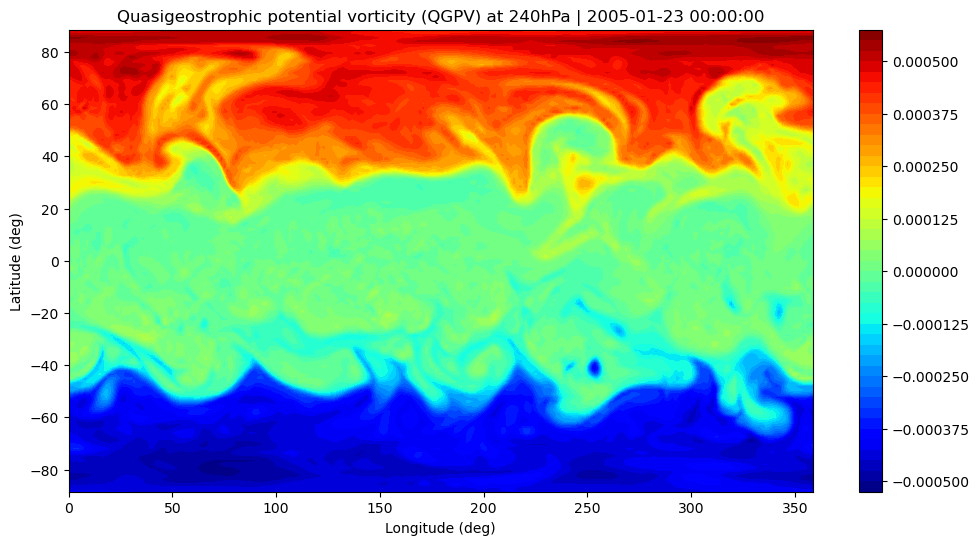

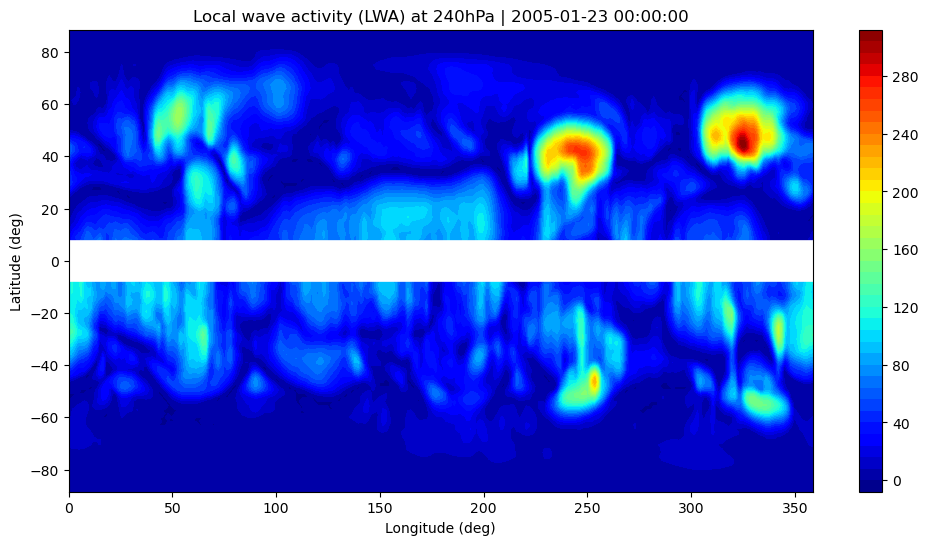

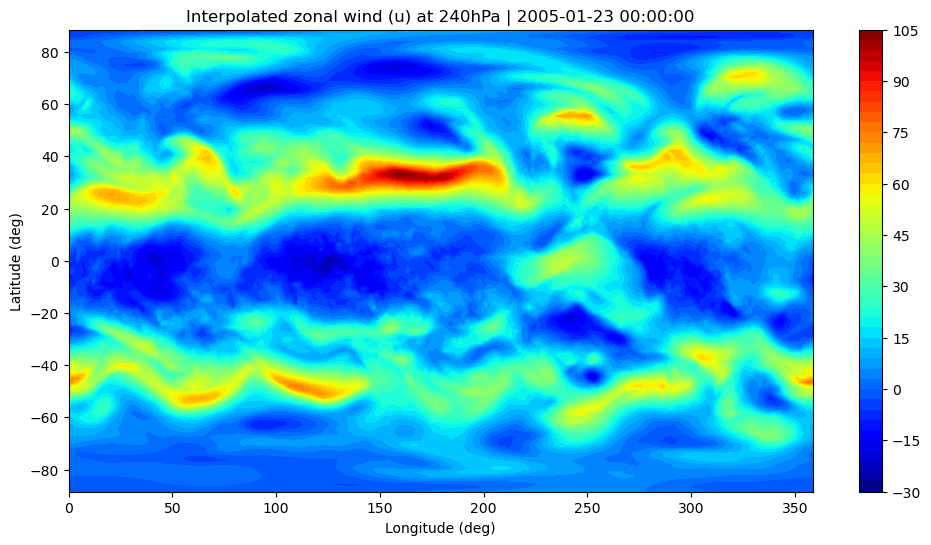

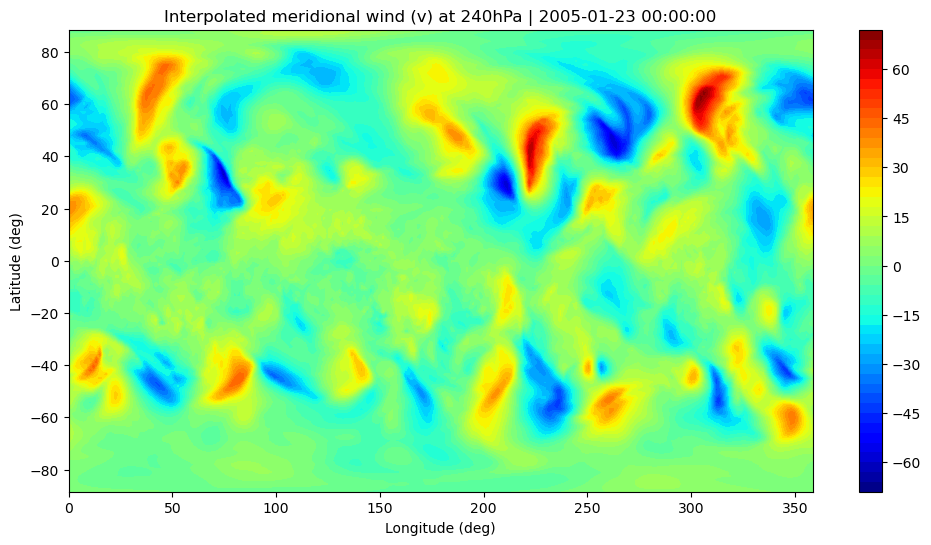

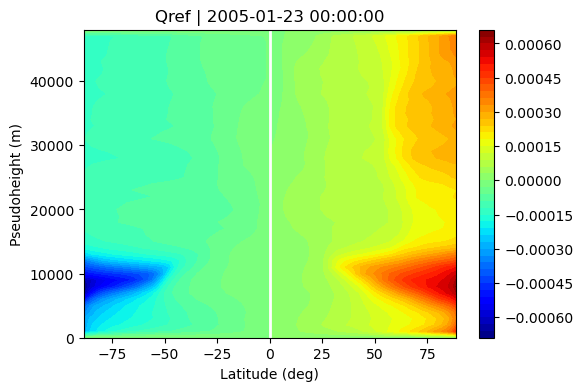

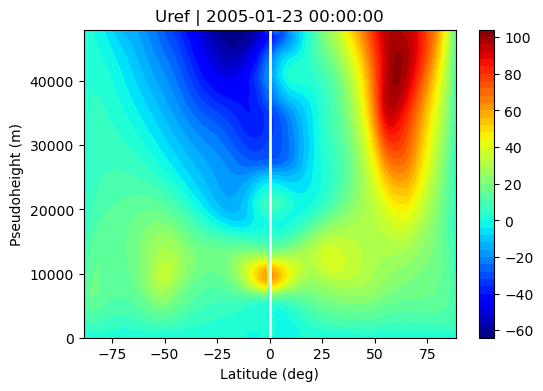

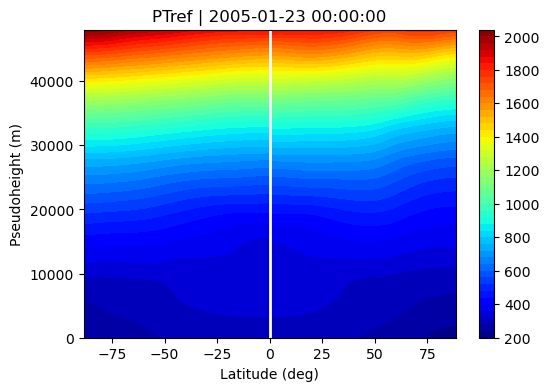

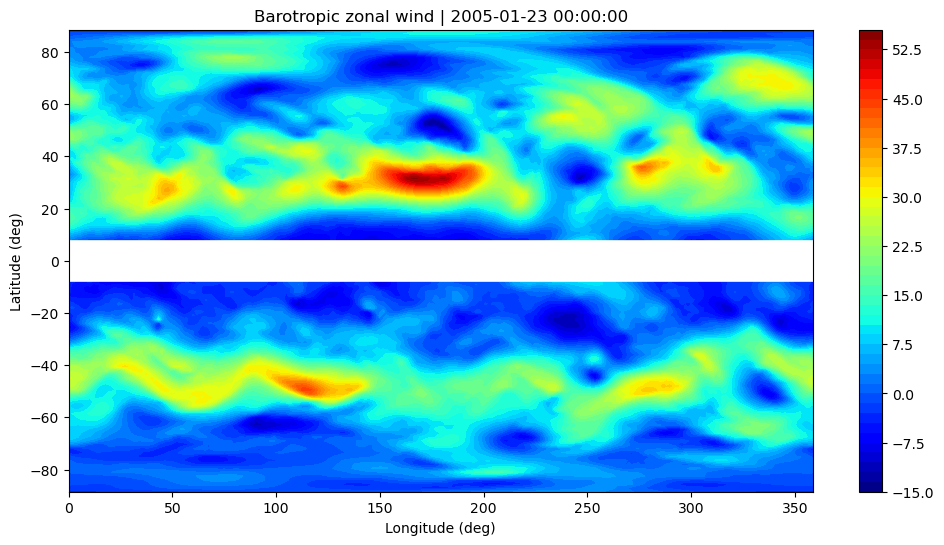

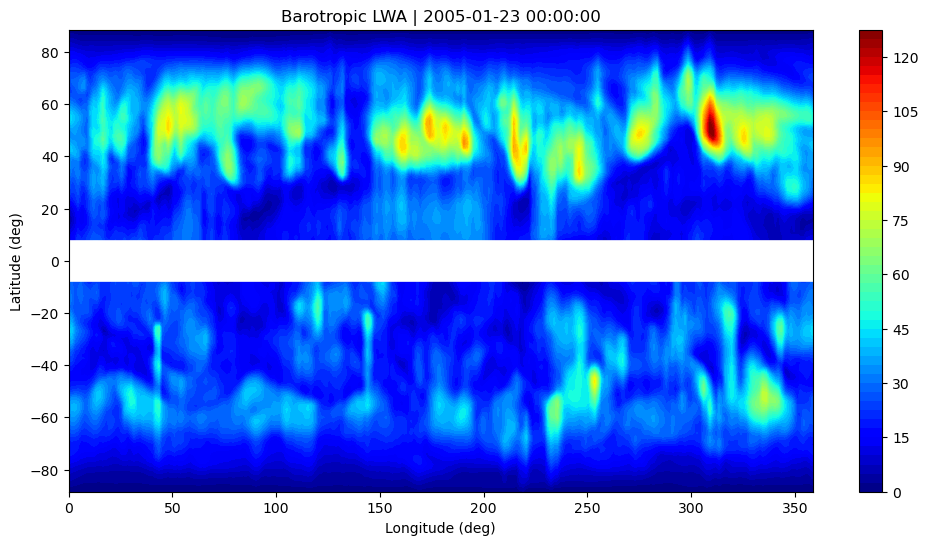

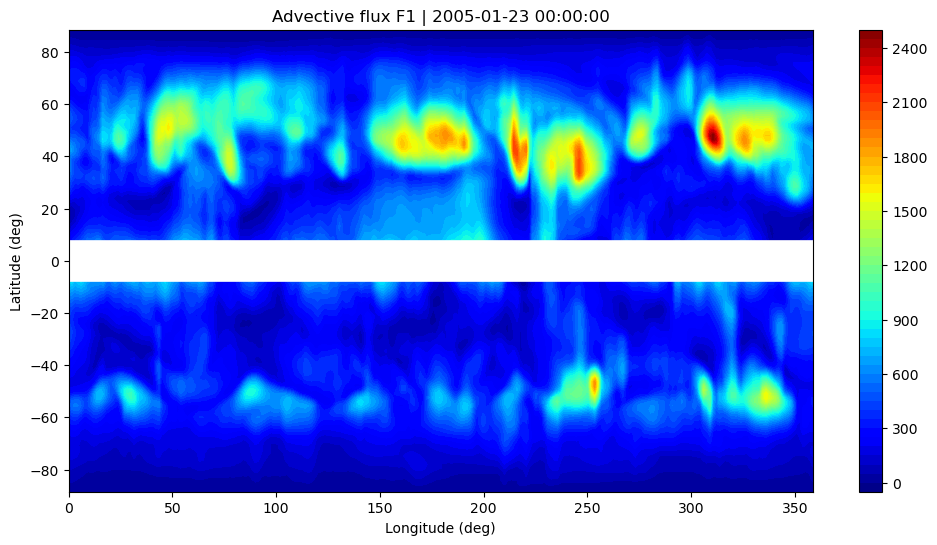

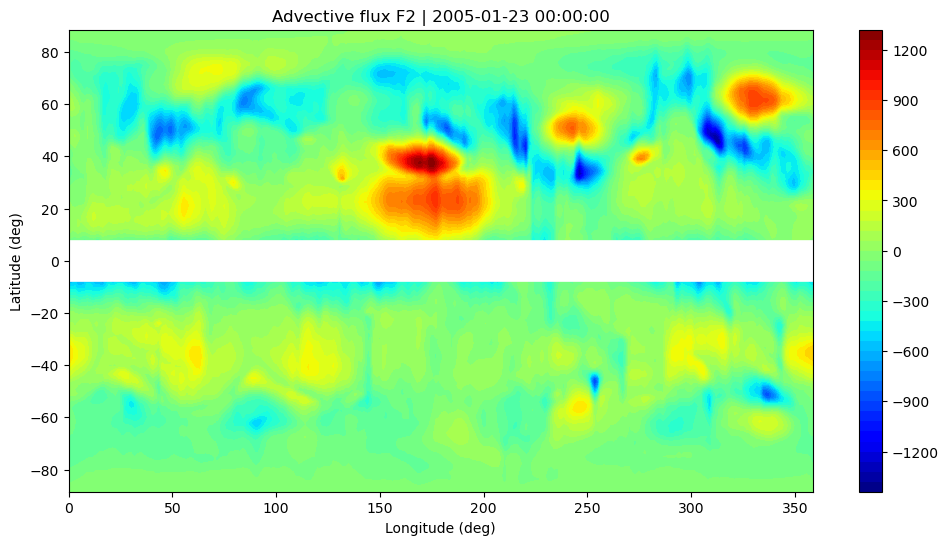

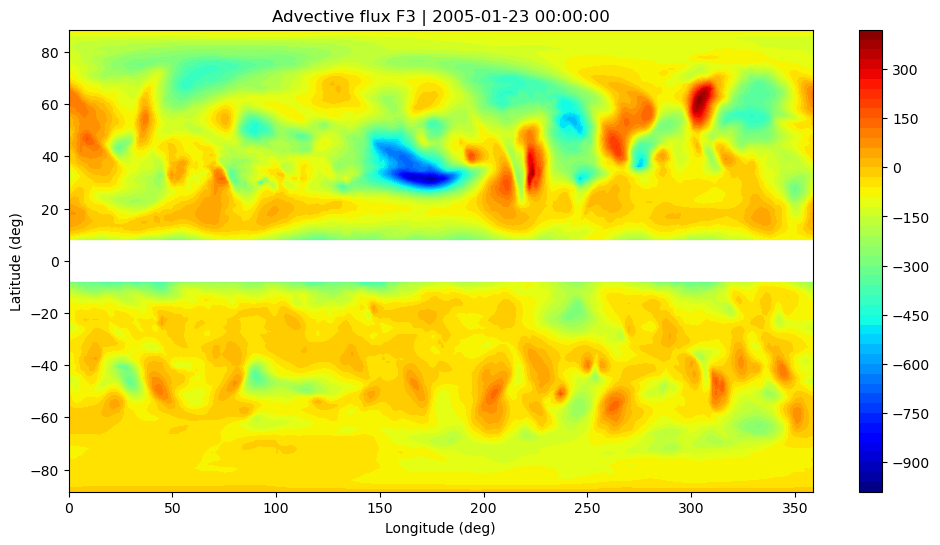

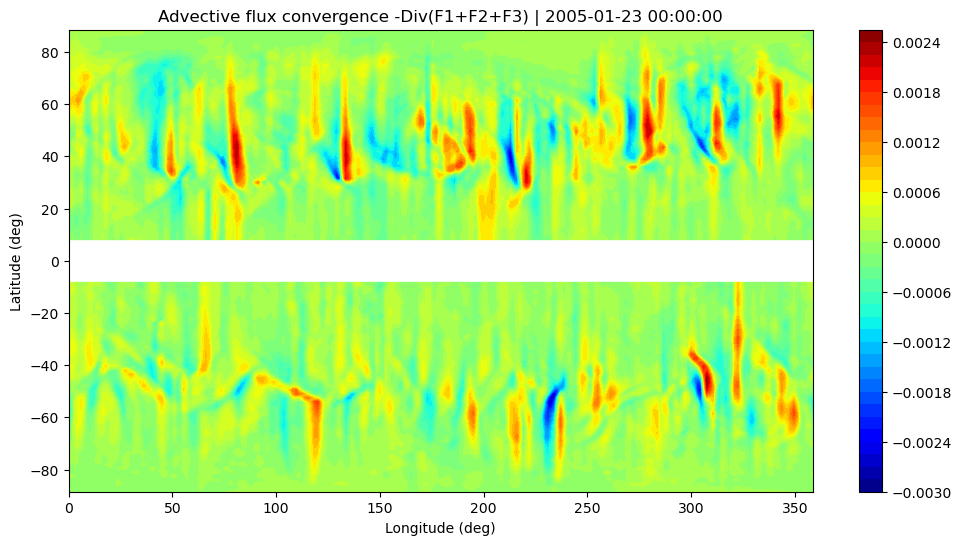

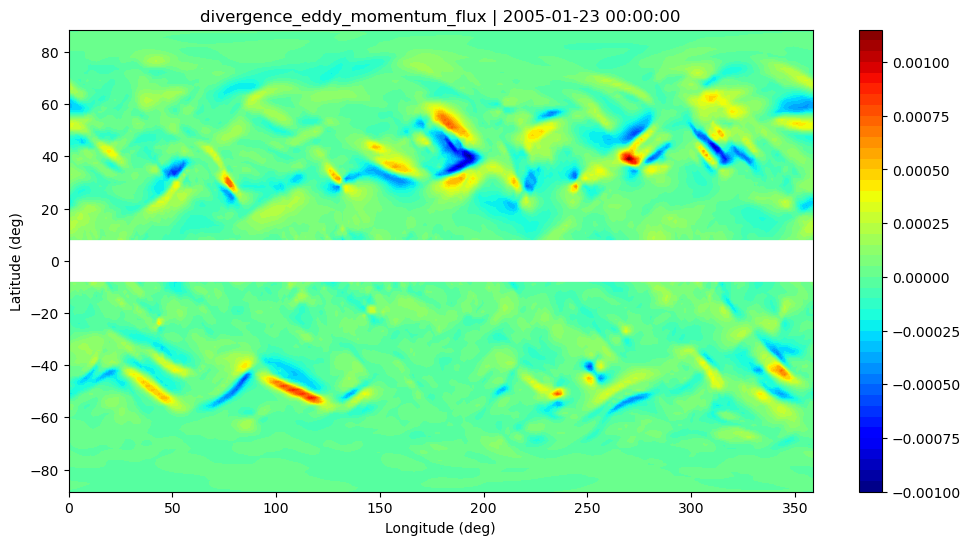

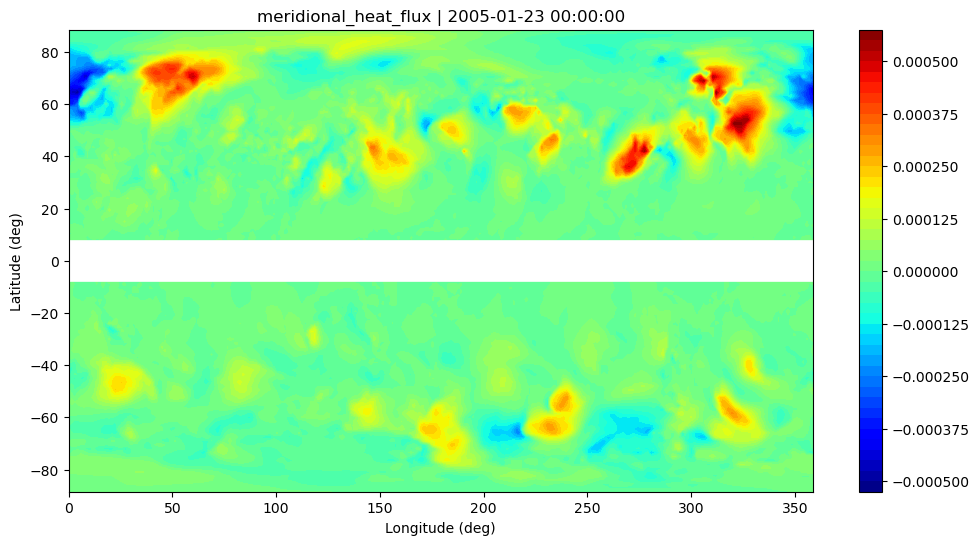

tstep = 0/32

Do scipy interpolation
   749925543           0           4  converged at n =          950
   749925543           0           4  converged at n =          722
tstep = 1/32

Do scipy interpolation
   749925543           0           4  converged at n =          949
   749925543           0           4  converged at n =          716
tstep = 2/32

Do scipy interpolation
   749925543           0           4  converged at n =          946
   749925543           0           4  converged at n =          719
tstep = 3/32

Do scipy interpolation
   749925543           0           4  converged at n =          946
   749925543           0           4  converged at n =          720
tstep = 4/32

Do scipy interpolation
   749925543           0           4  converged at n =          945
   749925543           0           4  converged at n =          720
tstep = 5/32

Do scipy interpolation
   749925543           0           4  converged at n =          941
   749925543           0      

In [24]:
for tstep in range(32):  # or ntimes
    
    uu = u_file.u.isel(valid_time=tstep).values[:, ::-1, :]
    vv = v_file.v.isel(valid_time=tstep).values[:, ::-1, :]
    tt = t_file.t.isel(valid_time=tstep).values[:, ::-1, :]

    qgfield_object = QGFieldNH18(xlon, ylat, plev, uu, vv, tt, northern_hemisphere_results_only=False)

    qgfield_object.interpolate_fields(return_named_tuple=False)
    
    qgfield_object.compute_reference_states(return_named_tuple=False)

    qgfield_object.compute_lwa_and_barotropic_fluxes(return_named_tuple=False)

    if tstep == tstep_selected:
        # === Below demonstrate another way to access the computed variables ===
        # 3D Variables that I would choose one pressure level to display
        variables_3d = [
            (qgfield_object.qgpv, 'Quasigeostrophic potential vorticity (QGPV)'),
            (qgfield_object.lwa, 'Local wave activity (LWA)'),
            (qgfield_object.interpolated_u, 'Interpolated zonal wind (u)'),
            (qgfield_object.interpolated_v, 'Interpolated meridional wind (v)')]

        # Reference states to be displayed on y-z plane
        variables_yz = [
            (qgfield_object.qref, 'Qref'),
            (qgfield_object.uref, 'Uref'),
            (qgfield_object.ptref, 'PTref')]

        # Vertically averaged variables to be displayed on x-y plane
        variables_xy = [
            (qgfield_object.u_baro, 'Barotropic zonal wind'),
            (qgfield_object.lwa_baro, 'Barotropic LWA'),
            (qgfield_object.adv_flux_f1, 'Advective flux F1'),
            (qgfield_object.adv_flux_f2, 'Advective flux F2'),
            (qgfield_object.adv_flux_f3, 'Advective flux F3'),
            (qgfield_object.convergence_zonal_advective_flux, 'Advective flux convergence -Div(F1+F2+F3)'),
            (qgfield_object.divergence_eddy_momentum_flux, 'divergence_eddy_momentum_flux'),
            (qgfield_object.meridional_heat_flux, 'meridional_heat_flux')
        ]
        
        # Plot 240 hPa of 3D-variables
        for variable, name in variables_3d:
            plt.figure(figsize=(12,6))
            plt.contourf(xlon, ylat[1:-1], variable[plev_selected, 1:-1, :], 50, cmap='jet')
            if name=='Local wave activity (LWA)':
                plt.axhline(y=0, c='w', lw=30)
            plt.colorbar()
            plt.ylabel('Latitude (deg)')
            plt.xlabel('Longitude (deg)')
            plt.title(name + ' at 240hPa | ' + str(tstamp[tstep]))
            plt.show()
        
        # Plot reference states
        for variable, name in variables_yz:
            plt.figure(figsize=(6,4))
            plt.contourf(ylat[1:-1], height, variable[:, 1:-1], 50, cmap='jet')
            plt.axvline(x=0, c='w', lw=2)
            plt.xlabel('Latitude (deg)')
            plt.ylabel('Pseudoheight (m)')
            plt.colorbar()
            plt.title(name + ' | ' + str(tstamp[tstep]))
            plt.show()

        # Plot barotropic (2D-)variables
        for variable, name in variables_xy:
            plt.figure(figsize=(12,6))
            plt.contourf(xlon, ylat[1:-1], variable[1:-1, :], 50, cmap='jet')
            plt.axhline(y=0, c='w', lw=30)
            plt.ylabel('Latitude (deg)')
            plt.xlabel('Longitude (deg)')
            plt.colorbar()
            plt.title(name + ' | ' + str(tstamp[tstep]))
            plt.show()

    print('tstep = {}/{}\n'.format(tstep, ntimes))
